# LinUCB

In this exercise, we will start looking at linear bandit with finite arms.

The set-up is captured by the following python class:

In [ ]:
import numpy as np
from matplotlib import pylab as plt
from tqdm import tqdm

# (4 choose 2)
available_arms = np.array([
  (1, 1, 0, 0),
  (1, 0, 1, 0),
  (1, 0, 0, 1),
  (0, 1, 1, 0),
  (0, 1, 0, 1),
  (0, 0, 1, 1)])

class context_arm(object):
  def __init__(self, available_arms=available_arms,gaussian_bandit=True):
    self.theta = np.array((0.1, 0.2, 0.2, 0.3))
    self.available_arms = np.array(available_arms)
    self.gaussian_bandit = gaussian_bandit

  def pull_arm(self, arm_idx):
    arm = self.available_arms[arm_idx]
    if self.gaussian_bandit:
      reward = self.theta.dot(arm) + np.random.randn() / 2 
    else:  # Bernoulli bandit
      reward = 1 if np.random.random()< self.theta.dot(arm) else 0
    return reward
  
  def genie_reward(self, arms=None):
    if not arms:
      arms = self.available_arms
    if self.gaussian_bandit:
      reward = np.max([self.theta.dot(arm) for arm in arms]) 
    else:  # Bernoulli bandit
      reward = np.max([self.theta.dot(arm) for arm in arms])
    return reward


## Goal of this exercise
1. Basic LinUCB algorithm implementation, for both Gaussian Reward and Bernoulli rewards
2. Plot the regret VS horizon ($n$).
3. Compare LinUCB with original UCB (for Gaussian rewards only) and KL-UCB (for Bernoulli rewards only)



In [ ]:
import sys
import numpy as np
import numpy.linalg as la
import numpy.random as rn
import matplotlib.pyplot as plt
rn.seed(0)

# LinUCB Implementation

In [ ]:
# LinUCB, returns regret per iteration like plots on Piazza
def linucb(n: int, alpha: float = 2, gaussian_bandit = True) -> float:

  # Initialize environment
  ca = context_arm(available_arms, gaussian_bandit)

  # Number of arms & context dimension
  k, d = ca.available_arms.shape

  # Initialize A, b
  A = np.zeros((k, d, d))
  for a_k in range(k):
    A[a_k] = np.identity(d)
  b = np.zeros((k, d))
  
  # Initialize theta, p
  theta = np.zeros((k, d))
  p = np.zeros(k)
  for a in range(k):
    x_a = ca.available_arms[a]
    p[a] = alpha * np.sqrt(np.matmul(np.matmul(x_a, la.inv(A[a])), x_a))

  # Track rewards & regret
  player_rewards = 0.
  genie_reward = ca.genie_reward()
  regret = []

  # Loop
  for t in range(n):
    # Pull best arm and save reward
    a_t = np.argmax(p)
    r_t = ca.pull_arm(a_t)
    player_rewards += r_t
    regret.append((t + 1) * genie_reward - player_rewards)
    # Update A, b, theta, p
    x_t = ca.available_arms[a_t]
    A[a_t] += np.matmul(x_t.reshape(-1, 1), x_t.reshape(1, -1))
    b[a_t] += r_t * x_t
    theta[a_t] = np.matmul(la.inv(A[a_t]), b[a_t])
    p[a_t] = np.dot(theta[a_t], x_t) + alpha * np.sqrt(np.matmul(np.matmul(x_t, la.inv(A[a_t])), x_t))

  return np.array(regret)

# Plot LinUCB regret vs. horizon for both Gaussian rewards and Bernoulli rewards

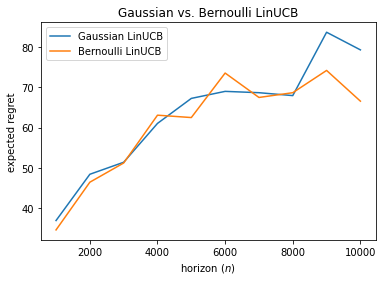

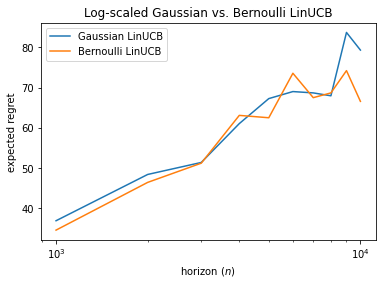

In [ ]:
def plot_linucb(n: int = 10000, num_runs: int = 10, num_runs_per_n: int = 100):
  regrets_g = np.zeros((num_runs, num_runs_per_n))
  regrets_b = np.zeros((num_runs, num_runs_per_n))
  n_list = np.zeros(num_runs)
  increment = int(n / num_runs)
  n_i = increment
  for i in range(num_runs):
    n_list[i] = n_i
    for j in range(num_runs_per_n):
      regrets_g[i][j] = linucb(n_i, gaussian_bandit = True)[-1]
      regrets_b[i][j] = linucb(n_i, gaussian_bandit = False)[-1]
    n_i += increment
  regret_linucb = np.average(regrets_g, axis=1)
  regret_ucb = np.average(regrets_b, axis=1)

  plt.clf()
  plt.plot(n_list, regret_linucb, label = 'Gaussian LinUCB')
  plt.plot(n_list, regret_ucb, label = 'Bernoulli LinUCB')
  plt.title('Gaussian vs. Bernoulli LinUCB')
  plt.xlabel('horizon ($n$)')
  plt.ylabel('expected regret')
  plt.legend()
  plt.show()
  plt.close()

  plt.clf()
  plt.semilogx(n_list, regret_linucb, label = 'Gaussian LinUCB')
  plt.semilogx(n_list, regret_ucb, label = 'Bernoulli LinUCB')
  plt.title('Log-scaled Gaussian vs. Bernoulli LinUCB')
  plt.xlabel('horizon ($n$)')
  plt.ylabel('expected regret')
  plt.legend()
  plt.show()
  plt.close()

plot_linucb()

# UCB Implementation

In [ ]:
# UCB, returns regret per iteration like plots on Piazza
def ucb(n: int) -> float:

  # Initialize environment
  ca = context_arm(available_arms, True)

  # Number of arms & context dimension
  k, d = ca.available_arms.shape

  # Calculate exploration constant
  delta = 1 / np.square(n)
  exploration_const = 2 * np.log(1 / delta)

  # Variables to track
  rewards_sum = np.zeros(k)
  rewards_count = np.ones(k)
  rewards_index = np.zeros(k)
  player_rewards = 0
  genie_reward = ca.genie_reward()
  regret = []

  # Pull each arm once
  for k_i in range(k):
    # Pull arm and save reward
    r_t = ca.pull_arm(k_i)
    player_rewards += r_t
    regret.append((k_i + 1) * genie_reward - player_rewards)
    # Update reward sum and mean
    rewards_sum[k_i] += r_t
    rewards_index[k_i] = (rewards_sum[k_i] / rewards_count[k_i]) + np.sqrt(exploration_const / rewards_count[k_i])
    

  # Loop
  for t in range(k, n):
    # Pull best arm and save reward
    k_i = np.argmax(rewards_index)
    r_t = ca.pull_arm(k_i)
    player_rewards += r_t
    regret.append((t + 1) * genie_reward - player_rewards)
    # Update reward sum, count, and mean
    rewards_sum[k_i] += r_t
    rewards_count[k_i] += 1
    rewards_index[k_i] = (rewards_sum[k_i] / rewards_count[k_i]) + np.sqrt(exploration_const / rewards_count[k_i])
    
  return np.array(regret)

# Compare LinUCB and UCB for Gaussian rewards

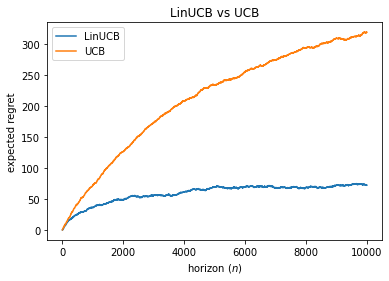

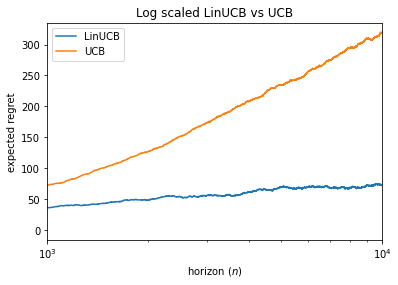

In [ ]:
def plot_linucb_vs_ucb(n: int = 10000, num_runs: int = 20):

  regret_linucb = np.zeros(n)
  regret_ucb = np.zeros(n)
  for run in range(num_runs):
    regret_linucb += linucb(n)
    regret_ucb += ucb(n)
  regret_linucb /= num_runs
  regret_ucb /= num_runs

  plt.clf()
  plt.plot(regret_linucb, label = 'LinUCB')
  plt.plot(regret_ucb, label = 'UCB')
  plt.title('LinUCB vs UCB')
  plt.xlabel('horizon ($n$)')
  plt.ylabel('expected regret')
  plt.legend()
  plt.show()
  plt.close()

  plt.clf()
  plt.semilogx(regret_linucb, label = 'LinUCB')
  plt.semilogx(regret_ucb, label = 'UCB')
  plt.xlim([1000, n])
  plt.title('Log scaled LinUCB vs UCB')
  plt.xlabel('horizon ($n$)')
  plt.ylabel('expected regret')
  plt.legend()
  plt.show()
  plt.close()

plot_linucb_vs_ucb()

# KL-UCB Implementation

In [ ]:
# f(t) for KL-UCB
def f(t: int) -> float:
  return 1 + t * (np.log(t) ** 2)

# KL-UCB, returns regret per iteration like plots on Piazza
def kl_ucb(n: int) -> float:
  
  # Initialize environment
  ca = context_arm(available_arms, False)
  
  # Number of arms & context dimension
  k, d = ca.available_arms.shape

  # Variables to track
  rewards_sum = np.zeros(k)
  rewards_count = np.ones(k)
  rewards_mean = np.zeros(k)
  arm_maxes = np.zeros(k)
  player_rewards = 0
  genie_reward = ca.genie_reward()
  regret = []

  # Pull each arm once
  for k_i in range(k):
    # Pull arm and save reward
    r_t = ca.pull_arm(k_i)
    player_rewards += r_t
    regret.append((k_i + 1) * genie_reward - player_rewards)
    # Update reward sum and mean
    rewards_sum[k_i] = r_t
    rewards_mean[k_i] = r_t
    
  # Use linspace to find optimistic empirical means
  mu_ls = np.linspace(0, 1)

  # Loop
  for t in range(k, n):
    # Calculate optimistic empirical means per arm by
    # approximating KL-divergence using Pisker's inequality
    opt_mu = np.sqrt(np.log(f(t)) / (2 * rewards_count)) + rewards_mean

    # Pull best arm and save reward
    best_arm = np.argmax(opt_mu)
    r_t = ca.pull_arm(best_arm)
    player_rewards += r_t
    regret.append((t + 1) * genie_reward - player_rewards)

    # Update reward sum, count, and mean
    rewards_sum[best_arm] += r_t
    rewards_count[best_arm] += 1
    rewards_mean[best_arm] = rewards_sum[best_arm] / rewards_count[best_arm]

  return regret

# Compare LinUCB and KL-UCB for Bernoulli rewards

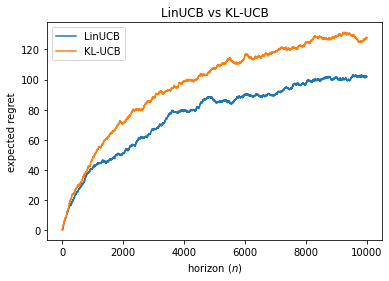

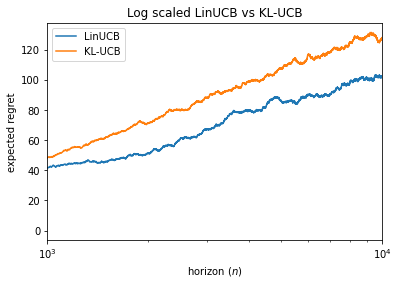

In [ ]:
def plot_linucb_vs_kl_ucb(n: int = 10000, num_runs: int = 20):

  regret_linucb = np.zeros(n)
  regret_kl_ucb = np.zeros(n)
  for run in range(num_runs):
    regret_linucb += linucb(n, gaussian_bandit = False)
    regret_kl_ucb += kl_ucb(n)
  regret_linucb /= num_runs
  regret_kl_ucb /= num_runs

  plt.clf()
  plt.plot(regret_linucb, label = 'LinUCB')
  plt.plot(regret_kl_ucb, label = 'KL-UCB')
  plt.title('LinUCB vs KL-UCB')
  plt.xlabel('horizon ($n$)')
  plt.ylabel('expected regret')
  plt.legend()
  plt.show()
  plt.close()

  plt.clf()
  plt.semilogx(regret_linucb, label = 'LinUCB')
  plt.semilogx(regret_kl_ucb, label = 'KL-UCB')
  plt.xlim([1000, n])
  plt.title('Log scaled LinUCB vs KL-UCB')
  plt.xlabel('horizon ($n$)')
  plt.ylabel('expected regret')
  plt.legend()
  plt.show()
  plt.close()

plot_linucb_vs_kl_ucb()